# ELO Scoring Function

In [1]:
import numpy as np
import seaborn as sns
sns.set()
import pandas as pd
from pandas import DataFrame as df
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from collections import Counter
import pickle

### Helper Functions

In [2]:
# Given eloA, and eloB, return the probability that A wins
def expected_prob(eloA, eloB):
    return 1 - (1 / (1+10**((eloA-eloB)/400)))

# Given eloA, eloB, constant = k, result of A. Return updated eloA, and eloB values
def update_elo(eloA, eloB, k, res):
    pa = expected_prob(eloA, eloB)
    eloA += (res - pa)*k
    eloB += ((1-res) - (1 - pa))*k
    return round(eloA,0), round(eloB,0)

def percentage(num):
    return round(num,4)*100

### Finding ELO on Datasets

In [3]:
# Example of ELO Calculation

eloA = 1200
eloB = 1000
pa = expected_prob(eloA, eloB)
print('Chance of A to win = ', percentage(pa), '%' )

res = 1 # A wins
eloA, eloB = update_elo(eloA, eloB, 100, res)
print('ELO of A = ', round(eloA, 0))
print('ELO of B = ', round(eloB, 0))

Chance of A to win =  75.97 %
ELO of A =  1224.0
ELO of B =  976.0


In [14]:
# See Bigger Dataframes]
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

For the ELO List, to improve efficiency could add players and update ELO as you run through the matches. For now, it initializes a list of all the players and the code pulls from the list.

In [5]:
def init_elo_df(trn_data):
    elo_df = df({'Player': [], 'Group': [], 'ELO': []})
    start_elo = 1000
    for idx, trn in enumerate(trn_data):
        if idx % 3 == 0:
            for player1 in trn:
                elo_df.loc[len(elo_df.index)] = [player1, 1, start_elo]
            for player2 in trn[player1]:
                elo_df.loc[len(elo_df.index)] = [player2, 2, start_elo]
    return elo_df

# Read pkl data
# trn_data is a list w/ length of 4, and dicts inside w/ length of 12
# 1st level is 4 tournaments, 2nd level is 12 p1's, 3rd level is 12 p2's, 4th level is match histories
file_name = "C:/Users/drago/OneDrive - UW/Ratliff Research/tournaments/smallsoccer-tournaments.pkl"
trn_data = pd.read_pickle(file_name)
elo_df = init_elo_df(trn_data)

In [6]:
# Output history dataframe (all data df) + ELO dataframe
hist_df = df({'Tournament': [], 'Player 1': [], 'Player 2': [], 'Result': [], 'Original ELO 1': [], 'New ELO 1': [], 'New ELO 2': []})
test_df = df({'Tournament': [], 'Player 1': [], 'Wins': [], 'Draws': [], 'Games': []})

k = 100
trnnum = 0
for trn in trn_data:
    trnnum += 1
    for player1 in trn:
        wins = 0
        draws = 0
        games = 0
        for player2 in trn[player1]:
            history = trn[player1][player2]
            for match in history:
                eloA = elo_df.loc[(elo_df['Player'] == player1) & (elo_df['Group'] == 1), 'ELO'].iloc[0] # Get ELO A
                eloB = elo_df.loc[(elo_df['Player'] == player2) & (elo_df['Group'] == 2), 'ELO'].iloc[0] # Get ELO B
                res = 0
                ret1 = match[0]
                ret2 = match[1]
                games += 1
                if (ret1 > ret2):
                    wins += 1
                    res = 1
                elif (ret1 == ret2):
                    draws += 1
                    res = 0.5
                new_eloA, new_eloB = update_elo(eloA, eloB, k, res) 
                elo_df.loc[(elo_df['Player'] == player1) & (elo_df['Group'] == 1), 'ELO'] = new_eloA # Update ELO A
                elo_df.loc[(elo_df['Player'] == player2) & (elo_df['Group'] == 2), 'ELO'] = new_eloB # Update ELO B
                hist_df.loc[len(hist_df.index)] = [trnnum, player1, player2, res, eloA, new_eloA, new_eloB]
        test_df.loc[len(test_df.index)] = [trnnum, player1, wins, draws, games]


### Data Analysis

In [15]:
# Wins / Draws / Games for Player 1
test_df.sort_values(by='Wins', ascending=False).head()

,Tournament,Player 1,Wins,Draws,Games
47,4.0,StackPG-smallsoccer-0_epochs100_batch_size1000_lr0.01_hidden_sizes[64]_-checkpoint.pt,120.0,0.0,120.0
12,2.0,SimplePG-smallsoccer-0_epochs100_batch_size5000_lr0.001_hidden_sizes[64]_-checkpoint.pt,120.0,0.0,120.0
37,4.0,"StackPG-smallsoccer-0_epochs100_batch_size1000_lr0.01_hidden_sizes[128, 64, 32]_-checkpoint.pt",120.0,0.0,120.0
40,4.0,StackPG-smallsoccer-0_epochs100_batch_size5000_lr0.01_hidden_sizes[64]_-checkpoint.pt,120.0,0.0,120.0
23,2.0,SimplePG-smallsoccer-0_epochs100_batch_size1000_lr0.001_hidden_sizes[32]_-checkpoint.pt,120.0,0.0,120.0


In [8]:
# Final ELO Rankings
player = 'SimplePG-smallsoccer-0_epochs100_batch_size5000_lr0.001_hidden_sizes[64]_-checkpoint.pt'
print(np.where(elo_df['Player'] == player)) # Group 1 and 2 treated as different players
elo_df.sort_values(by='ELO', ascending=False)

(array([ 0, 12], dtype=int64),)


,Player,Group,ELO
0,SimplePG-smallsoccer-0_epochs100_batch_size5000_lr0.001_hidden_sizes[64]_-checkpoint.pt,1.0,1706.0
1,SimplePG-smallsoccer-0_epochs100_batch_size1000_lr0.01_hidden_sizes[64]_-checkpoint.pt,1.0,1666.0
2,"SimplePG-smallsoccer-0_epochs100_batch_size5000_lr0.001_hidden_sizes[128, 64, 32]_-checkpoint.pt",1.0,1583.0
4,SimplePG-smallsoccer-0_epochs100_batch_size1000_lr0.01_hidden_sizes[32]_-checkpoint.pt,1.0,1538.0
3,SimplePG-smallsoccer-0_epochs100_batch_size5000_lr0.001_hidden_sizes[32]_-checkpoint.pt,1.0,1531.0
5,"SimplePG-smallsoccer-0_epochs100_batch_size5000_lr0.01_hidden_sizes[128, 64, 32]_-checkpoint.pt",1.0,1479.0
7,SimplePG-smallsoccer-0_epochs100_batch_size5000_lr0.01_hidden_sizes[64]_-checkpoint.pt,1.0,1449.0
8,"SimplePG-smallsoccer-0_epochs100_batch_size1000_lr0.001_hidden_sizes[128, 64, 32]_-checkpoint.pt",1.0,1442.0
6,SimplePG-smallsoccer-0_epochs100_batch_size5000_lr0.01_hidden_sizes[32]_-checkpoint.pt,1.0,1438.0
9,"SimplePG-smallsoccer-0_epochs100_batch_size1000_lr0.01_hidden_sizes[128, 64, 32]_-checkpoint.pt",1.0,1359.0


In [9]:
hist_df.head()

,Tournament,Player 1,Player 2,Result,Original ELO 1,New ELO 1,New ELO 2
0,1.0,SimplePG-smallsoccer-0_epochs100_batch_size5000_lr0.001_hidden_sizes[64]_-checkpoint.pt,SimplePG-smallsoccer-0_epochs100_batch_size5000_lr0.001_hidden_sizes[64]_-checkpoint.pt,0.0,1000.0,950.0,1050.0
1,1.0,SimplePG-smallsoccer-0_epochs100_batch_size5000_lr0.001_hidden_sizes[64]_-checkpoint.pt,SimplePG-smallsoccer-0_epochs100_batch_size5000_lr0.001_hidden_sizes[64]_-checkpoint.pt,1.0,950.0,1014.0,986.0
2,1.0,SimplePG-smallsoccer-0_epochs100_batch_size5000_lr0.001_hidden_sizes[64]_-checkpoint.pt,SimplePG-smallsoccer-0_epochs100_batch_size5000_lr0.001_hidden_sizes[64]_-checkpoint.pt,1.0,1014.0,1060.0,940.0
3,1.0,SimplePG-smallsoccer-0_epochs100_batch_size5000_lr0.001_hidden_sizes[64]_-checkpoint.pt,SimplePG-smallsoccer-0_epochs100_batch_size5000_lr0.001_hidden_sizes[64]_-checkpoint.pt,1.0,1060.0,1093.0,907.0
4,1.0,SimplePG-smallsoccer-0_epochs100_batch_size5000_lr0.001_hidden_sizes[64]_-checkpoint.pt,SimplePG-smallsoccer-0_epochs100_batch_size5000_lr0.001_hidden_sizes[64]_-checkpoint.pt,1.0,1093.0,1119.0,881.0


<AxesSubplot:xlabel='Player 1'>

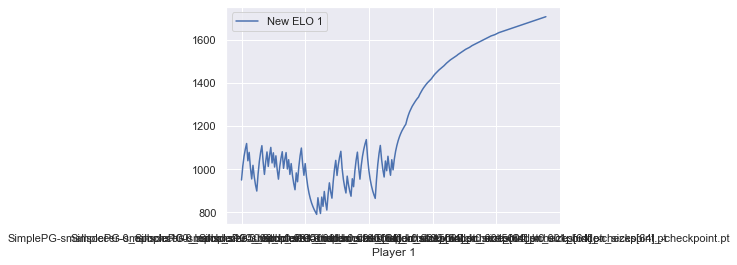

In [11]:
# Best Player
player = 'SimplePG-smallsoccer-0_epochs100_batch_size5000_lr0.001_hidden_sizes[64]_-checkpoint.pt'
group = 1
hist_df_players = hist_df.groupby('Player ' + str(group))
hist_df_player = hist_df_players.get_group(player)

#hist_df_player

hist_df_player.plot(x = 'Player 1', y = 'New ELO 1')

<AxesSubplot:xlabel='Player 2'>

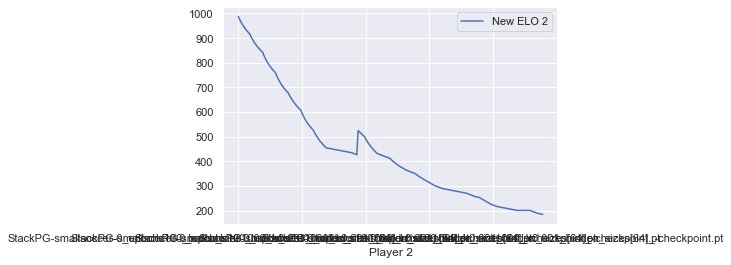

In [12]:
# Worst Player
player = 'StackPG-smallsoccer-0_epochs100_batch_size1000_lr0.001_hidden_sizes[64]_-checkpoint.pt'
group = 2
hist_df_players = hist_df.groupby('Player ' + str(group))
hist_df_player = hist_df_players.get_group(player)

#hist_df_player

hist_df_player.plot(x = 'Player 2', y = 'New ELO 2')

In [16]:
# Example of Cost Matrix
def f(a, b):

    return a * b

x = np.array([1, 2, 3])
y = np.array([1, 2, 3])

cost_mat = np.zeros((x.shape[0], y.shape[0]))

for i in range(x.shape[0]):
    for j in range(y.shape[0]):
        cost_mat[i, j] = f(x[i], y[j])
        
print('\nCost Matrix\n')
print(cost_mat)



Cost Matrix

[[1. 2. 3.]
 [2. 4. 6.]
 [3. 6. 9.]]
